# Feature Engineering & Model Building 

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split,GridSearchCV

In [2]:
# Load the data
client_df = pd.read_csv('DATASET\\client_data.csv')
price_df = pd.read_csv('DATASET\\price_data.csv')

## Feature Engineering 

In [3]:
# Convert 'MISSING' to NaN
client_df = client_df.replace('MISSING', np.nan)
client_df.isna().sum()

id                                   0
channel_sales                     3725
cons_12m                             0
cons_gas_12m                         0
cons_last_month                      0
date_activ                           0
date_end                             0
date_modif_prod                      0
date_renewal                         0
forecast_cons_12m                    0
forecast_cons_year                   0
forecast_discount_energy             0
forecast_meter_rent_12m              0
forecast_price_energy_off_peak       0
forecast_price_energy_peak           0
forecast_price_pow_off_peak          0
has_gas                              0
imp_cons                             0
margin_gross_pow_ele                 0
margin_net_pow_ele                   0
nb_prod_act                          0
net_margin                           0
num_years_antig                      0
origin_up                           64
pow_max                              0
churn                    

In [4]:
print(client_df.head())
print('\n',price_df.head())

                                 id                     channel_sales  \
0  24011ae4ebbe3035111d65fa7c15bc57  foosdfpfkusacimwkcsosbicdxkicaua   
1  d29c2c54acc38ff3c0614d0a653813dd                               NaN   
2  764c75f661154dac3a6c254cd082ea7d  foosdfpfkusacimwkcsosbicdxkicaua   
3  bba03439a292a1e166f80264c16191cb  lmkebamcaaclubfxadlmueccxoimlema   
4  149d57cf92fc41cf94415803a877cb4b                               NaN   

   cons_12m  cons_gas_12m  cons_last_month  date_activ    date_end  \
0         0         54946                0  2013-06-15  2016-06-15   
1      4660             0                0  2009-08-21  2016-08-30   
2       544             0                0  2010-04-16  2016-04-16   
3      1584             0                0  2010-03-30  2016-03-30   
4      4425             0              526  2010-01-13  2016-03-07   

  date_modif_prod date_renewal  forecast_cons_12m  ...  has_gas  imp_cons  \
0      2015-11-01   2015-06-23               0.00  ...        t

In [5]:
# Convert date columns to datetime in client_df
client_df['date_activ'] = pd.to_datetime(client_df['date_activ'], format='%Y-%m-%d')
client_df['date_end'] = pd.to_datetime(client_df['date_end'], format='%Y-%m-%d')
client_df['date_modif_prod'] = pd.to_datetime(client_df['date_modif_prod'], format='%Y-%m-%d')
client_df['date_renewal'] = pd.to_datetime(client_df['date_renewal'], format='%Y-%m-%d')

In [6]:
# Convert date columns to datetime in price_df
price_df['price_date'] = pd.to_datetime(price_df['price_date'], format='%Y-%m-%d')

In [7]:
# check for missing values in price_df
price_df.isna().sum()

id                    0
price_date            0
price_off_peak_var    0
price_peak_var        0
price_mid_peak_var    0
price_off_peak_fix    0
price_peak_fix        0
price_mid_peak_fix    0
dtype: int64

In [8]:
# Sum of prices of energy and power for each period
price_df['price_period1'] = price_df['price_off_peak_var'] + price_df['price_off_peak_fix']
price_df['price_period2'] = price_df['price_peak_var'] + price_df['price_peak_fix']
price_df['price_period3'] = price_df['price_mid_peak_var'] + price_df['price_mid_peak_fix']

# Difference between periods
price_df['price_diff12'] = price_df['price_period2'] - price_df['price_period1']
price_df['price_diff23'] = price_df['price_period3'] - price_df['price_period2']
price_df['price_diff13'] = price_df['price_period3'] - price_df['price_period1']

price_df.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix,price_period1,price_period2,price_period3,price_diff12,price_diff23,price_diff13
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0,44.418298,0.0,0.0,-44.418298,0.0,-44.418298
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0,44.418298,0.0,0.0,-44.418298,0.0,-44.418298
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0,44.418298,0.0,0.0,-44.418298,0.0,-44.418298
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0,44.416557,0.0,0.0,-44.416557,0.0,-44.416557
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0,44.416557,0.0,0.0,-44.416557,0.0,-44.416557


- Sum of Prices for Energy and Power:
    - The combined price for energy and power is analyzed for its relationship to churn.
- Price Difference Across Periods:
    - The difference in energy and power prices across time periods is a critical factor.
    - Changes in prices are expected to correlate with churn behavior.

#### Difference between prices in 1st period of Dec & Jan

In [9]:
monthly_price_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 
                                                               'price_off_peak_fix': 'mean',}).reset_index() # mean of prices for each id and price_date

# Get the first and last price for each id
jan_price = monthly_price_id.groupby('id').first().reset_index()
dec_price = monthly_price_id.groupby('id').last().reset_index()

# Calculate the difference
diff_period1 = pd.merge(dec_price.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), 
                  jan_price.rename(columns={'price_off_peak_var': 'jan_1', 'price_off_peak_fix': 'jan_2'}).drop(columns='price_date'), on='id')
diff_period1['diff_dec_jan_energy_period1'] = diff_period1['dec_1'] - diff_period1['jan_1']
diff_period1['diff_dec_jan_pow_period1'] = diff_period1['dec_2'] - diff_period1['jan_2']
diff_period1 = diff_period1[['id', 'diff_dec_jan_energy_period1','diff_dec_jan_pow_period1']]
diff_period1.head()

,id,diff_dec_jan_energy_period1,diff_dec_jan_pow_period1
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001


#### Difference between prices in 2nd period of Dec & Jan

In [10]:
monthly_price_id = price_df.groupby(['id', 'price_date']).agg({'price_peak_var': 'mean', 
                                                               'price_peak_fix': 'mean',}).reset_index()

# Get january and december prices
jan_price = monthly_price_id.groupby('id').first().reset_index()
dec_price = monthly_price_id.groupby('id').last().reset_index() 

# calculate the difference between the first and last price for each id for period 2
diff_period2 = pd.merge(dec_price.rename(columns={'price_peak_var': 'dec_1', 'price_peak_fix': 'dec_2'}), 
                  jan_price.rename(columns={'price_peak_var': 'jan_1', 'price_peak_fix': 'jan_2'}).drop(columns='price_date'), on='id')
diff_period2['diff_dec_jan_energy_period2'] = diff_period2['dec_1'] - diff_period2['jan_1']
diff_period2['diff_dec_jan_pow_period2'] = diff_period2['dec_2'] - diff_period2['jan_2']
diff_period2 = diff_period2[['id', 'diff_dec_jan_energy_period2','diff_dec_jan_pow_period2']]
diff_period2.head()

,id,diff_dec_jan_energy_period2,diff_dec_jan_pow_period2
0,0002203ffbb812588b632b9e628cc38d,-0.002302,0.097749
1,0004351ebdd665e6ee664792efc4fd13,0.000000,0.000000
2,0010bcc39e42b3c2131ed2ce55246e3c,0.000000,0.000000
3,0010ee3855fdea87602a5b7aba8e42de,-0.005120,0.097749
4,00114d74e963e47177db89bc70108537,0.000000,0.000000


#### Difference between prices in 3rd period of Dec & Jan

In [11]:
# Group off-peak prices by companies and month
monthly_price_id = price_df.groupby(['id', 'price_date']).agg({'price_mid_peak_var': 'mean', 'price_mid_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_price = monthly_price_id.groupby('id').first().reset_index()
dec_price = monthly_price_id.groupby('id').last().reset_index()

# Calculate the difference
diff_period3 = pd.merge(dec_price.rename(columns={'price_mid_peak_var': 'dec_1', 'price_mid_peak_fix': 'dec_2'}), 
                        jan_price.rename(columns={'price_mid_peak_var': 'jan_1', 'price_mid_peak_fix': 'jan_2'}).drop(columns='price_date'), on='id')
diff_period3['diff_dec_jan_energy_period3'] = diff_period3['dec_1'] - diff_period3['jan_1']
diff_period3['diff_dec_jan_pow_period3'] = diff_period3['dec_2'] - diff_period3['jan_2']
diff_period3 = diff_period3[['id', 'diff_dec_jan_energy_period3','diff_dec_jan_pow_period3']]
diff_period3.head()

,id,diff_dec_jan_energy_period3,diff_dec_jan_pow_period3
0,0002203ffbb812588b632b9e628cc38d,0.003487,0.065166
1,0004351ebdd665e6ee664792efc4fd13,0.000000,0.000000
2,0010bcc39e42b3c2131ed2ce55246e3c,0.000000,0.000000
3,0010ee3855fdea87602a5b7aba8e42de,0.000763,0.065166
4,00114d74e963e47177db89bc70108537,0.000000,0.000000


In [12]:
diff = pd.merge(pd.merge(diff_period1, diff_period2, on='id'), diff_period3, on='id')
diff.head()

,id,diff_dec_jan_energy_period1,diff_dec_jan_pow_period1,diff_dec_jan_energy_period2,diff_dec_jan_pow_period2,diff_dec_jan_energy_period3,diff_dec_jan_pow_period3
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916,-0.002302,0.097749,0.003487,0.065166
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779,0.000000,0.000000,0.000000,0.000000
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000,0.000000,0.000000,0.000000,0.000000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916,-0.005120,0.097749,0.000763,0.065166
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001,0.000000,0.000000,0.000000,0.000000


#### Tenure of client  in the company

In [13]:
client_df['tenure'] = (client_df['date_end'] - client_df['date_activ']).dt.days/365
client_df['tenure'].head()

0    3.002740
1    7.030137
2    6.005479
3    6.005479
4    6.150685
Name: tenure, dtype: float64

### Consumption Deviation in one month
- Dividing the cons_12m (12-month total consumption) by 12 to compute the average monthly consumption.
- Subtracting cons_last_month (consumption in the last month) to compute the deviation.

In [14]:
client_df['cons_dev']=(client_df['cons_12m']/12)-client_df['cons_last_month']
client_df['cons_dev'].describe()

count     14606.000000
mean      -2821.912564
std       21686.353629
min     -449656.000000
25%        -496.312500
50%         105.125000
75%         757.375000
max      194525.250000
Name: cons_dev, dtype: float64

In [15]:
client_df['cons_dev'].isna().sum()

0

#### Consumption of forcasted year by current year

In [16]:
# forcasted consumption for 12 months divided by the average consumption for 12 months gives the consumption pattern in a year
client_df['cons_year_pattern']=client_df['forecast_cons_12m']/client_df['cons_12m']
client_df['cons_year_pattern'].describe()

count    1.450600e+04
mean              inf
std               NaN
min      0.000000e+00
25%      4.496907e-02
50%      1.024782e-01
75%      1.475232e-01
max               inf
Name: cons_year_pattern, dtype: float64

In [17]:
# handle infinite values
def handleInf(x):
    if x==float('-inf') or x==float('inf'):
        return 0
    else:
        return x

client_df['cons_year_pattern'] = client_df['cons_year_pattern'].apply(handleInf)
client_df['cons_year_pattern'].describe()

count    14506.000000
mean         0.093761
std          0.054838
min          0.000000
25%          0.044747
50%          0.102414
75%          0.147496
max          0.624622
Name: cons_year_pattern, dtype: float64

In [18]:
# Missing values in cons_year_pattern

client_df['cons_year_pattern'].isna().sum()

100

In [19]:
client_df['cons_year_pattern'].fillna(0, inplace=True)

In [20]:
client_df.head()    

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn,tenure,cons_dev,cons_year_pattern
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1,3.002740,0.000000,0.000000
1,d29c2c54acc38ff3c0614d0a653813dd,NaN,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0,7.030137,388.333333,0.040762
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0,6.005479,45.333333,0.088162
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,30.22,1,25.46,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0,6.005479,132.000000,0.151540
4,149d57cf92fc41cf94415803a877cb4b,NaN,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,44.91,1,47.98,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,19.800,0,6.150685,-157.250000,0.100734


In [21]:
# Encode the categorical columns channel_sales and origin_up
le = LabelEncoder()
client_df['channel_sales'] = le.fit_transform(client_df['channel_sales'])
client_df['origin_up'] = le.fit_transform(client_df['origin_up'])

In [22]:
client_df['has_gas'] = client_df['has_gas'].replace({'f': 0, 't': 1})
client_df['has_gas'].head()

0    1
1    0
2    0
3    0
4    0
Name: has_gas, dtype: int64

#### Merging the Final Data for Modeling

In [23]:
df = pd.merge(price_df.drop(['price_date', 'price_off_peak_var', 'price_off_peak_fix', 'price_peak_var',
                                'price_peak_fix', 'price_mid_peak_var', 'price_mid_peak_fix'], axis=1), 
                 client_df.drop(['date_activ', 'date_end', 'date_modif_prod', 'date_renewal'], axis=1), on='id')

In [24]:
df.shape

(175149, 31)

#### Checking for Missing and Duplicate Values

In [25]:
df.isna().sum()
print("No.of duplicates:",df.duplicated().sum())
df.drop_duplicates(inplace=True)
print("No.of duplicates:",df.duplicated().sum())

No.of duplicates: 118780
No.of duplicates: 0


In [26]:
X = df.drop(['id', 'churn'], axis=1)
y = df['churn']
X.dtypes

price_period1                     float64
price_period2                     float64
price_period3                     float64
price_diff12                      float64
price_diff23                      float64
price_diff13                      float64
channel_sales                       int32
cons_12m                            int64
cons_gas_12m                        int64
cons_last_month                     int64
forecast_cons_12m                 float64
forecast_cons_year                  int64
forecast_discount_energy          float64
forecast_meter_rent_12m           float64
forecast_price_energy_off_peak    float64
forecast_price_energy_peak        float64
forecast_price_pow_off_peak       float64
has_gas                             int64
imp_cons                          float64
margin_gross_pow_ele              float64
margin_net_pow_ele                float64
nb_prod_act                         int64
net_margin                        float64
num_years_antig                   

## Model Building

##### Splitting the Data into Train and Test

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,random_state=42)

In [28]:
X_train.shape, X_test.shape

((45095, 29), (11274, 29))

In [29]:
y_train.shape, y_test.shape

((45095,), (11274,))

#### Feature Importance

<AxesSubplot:>

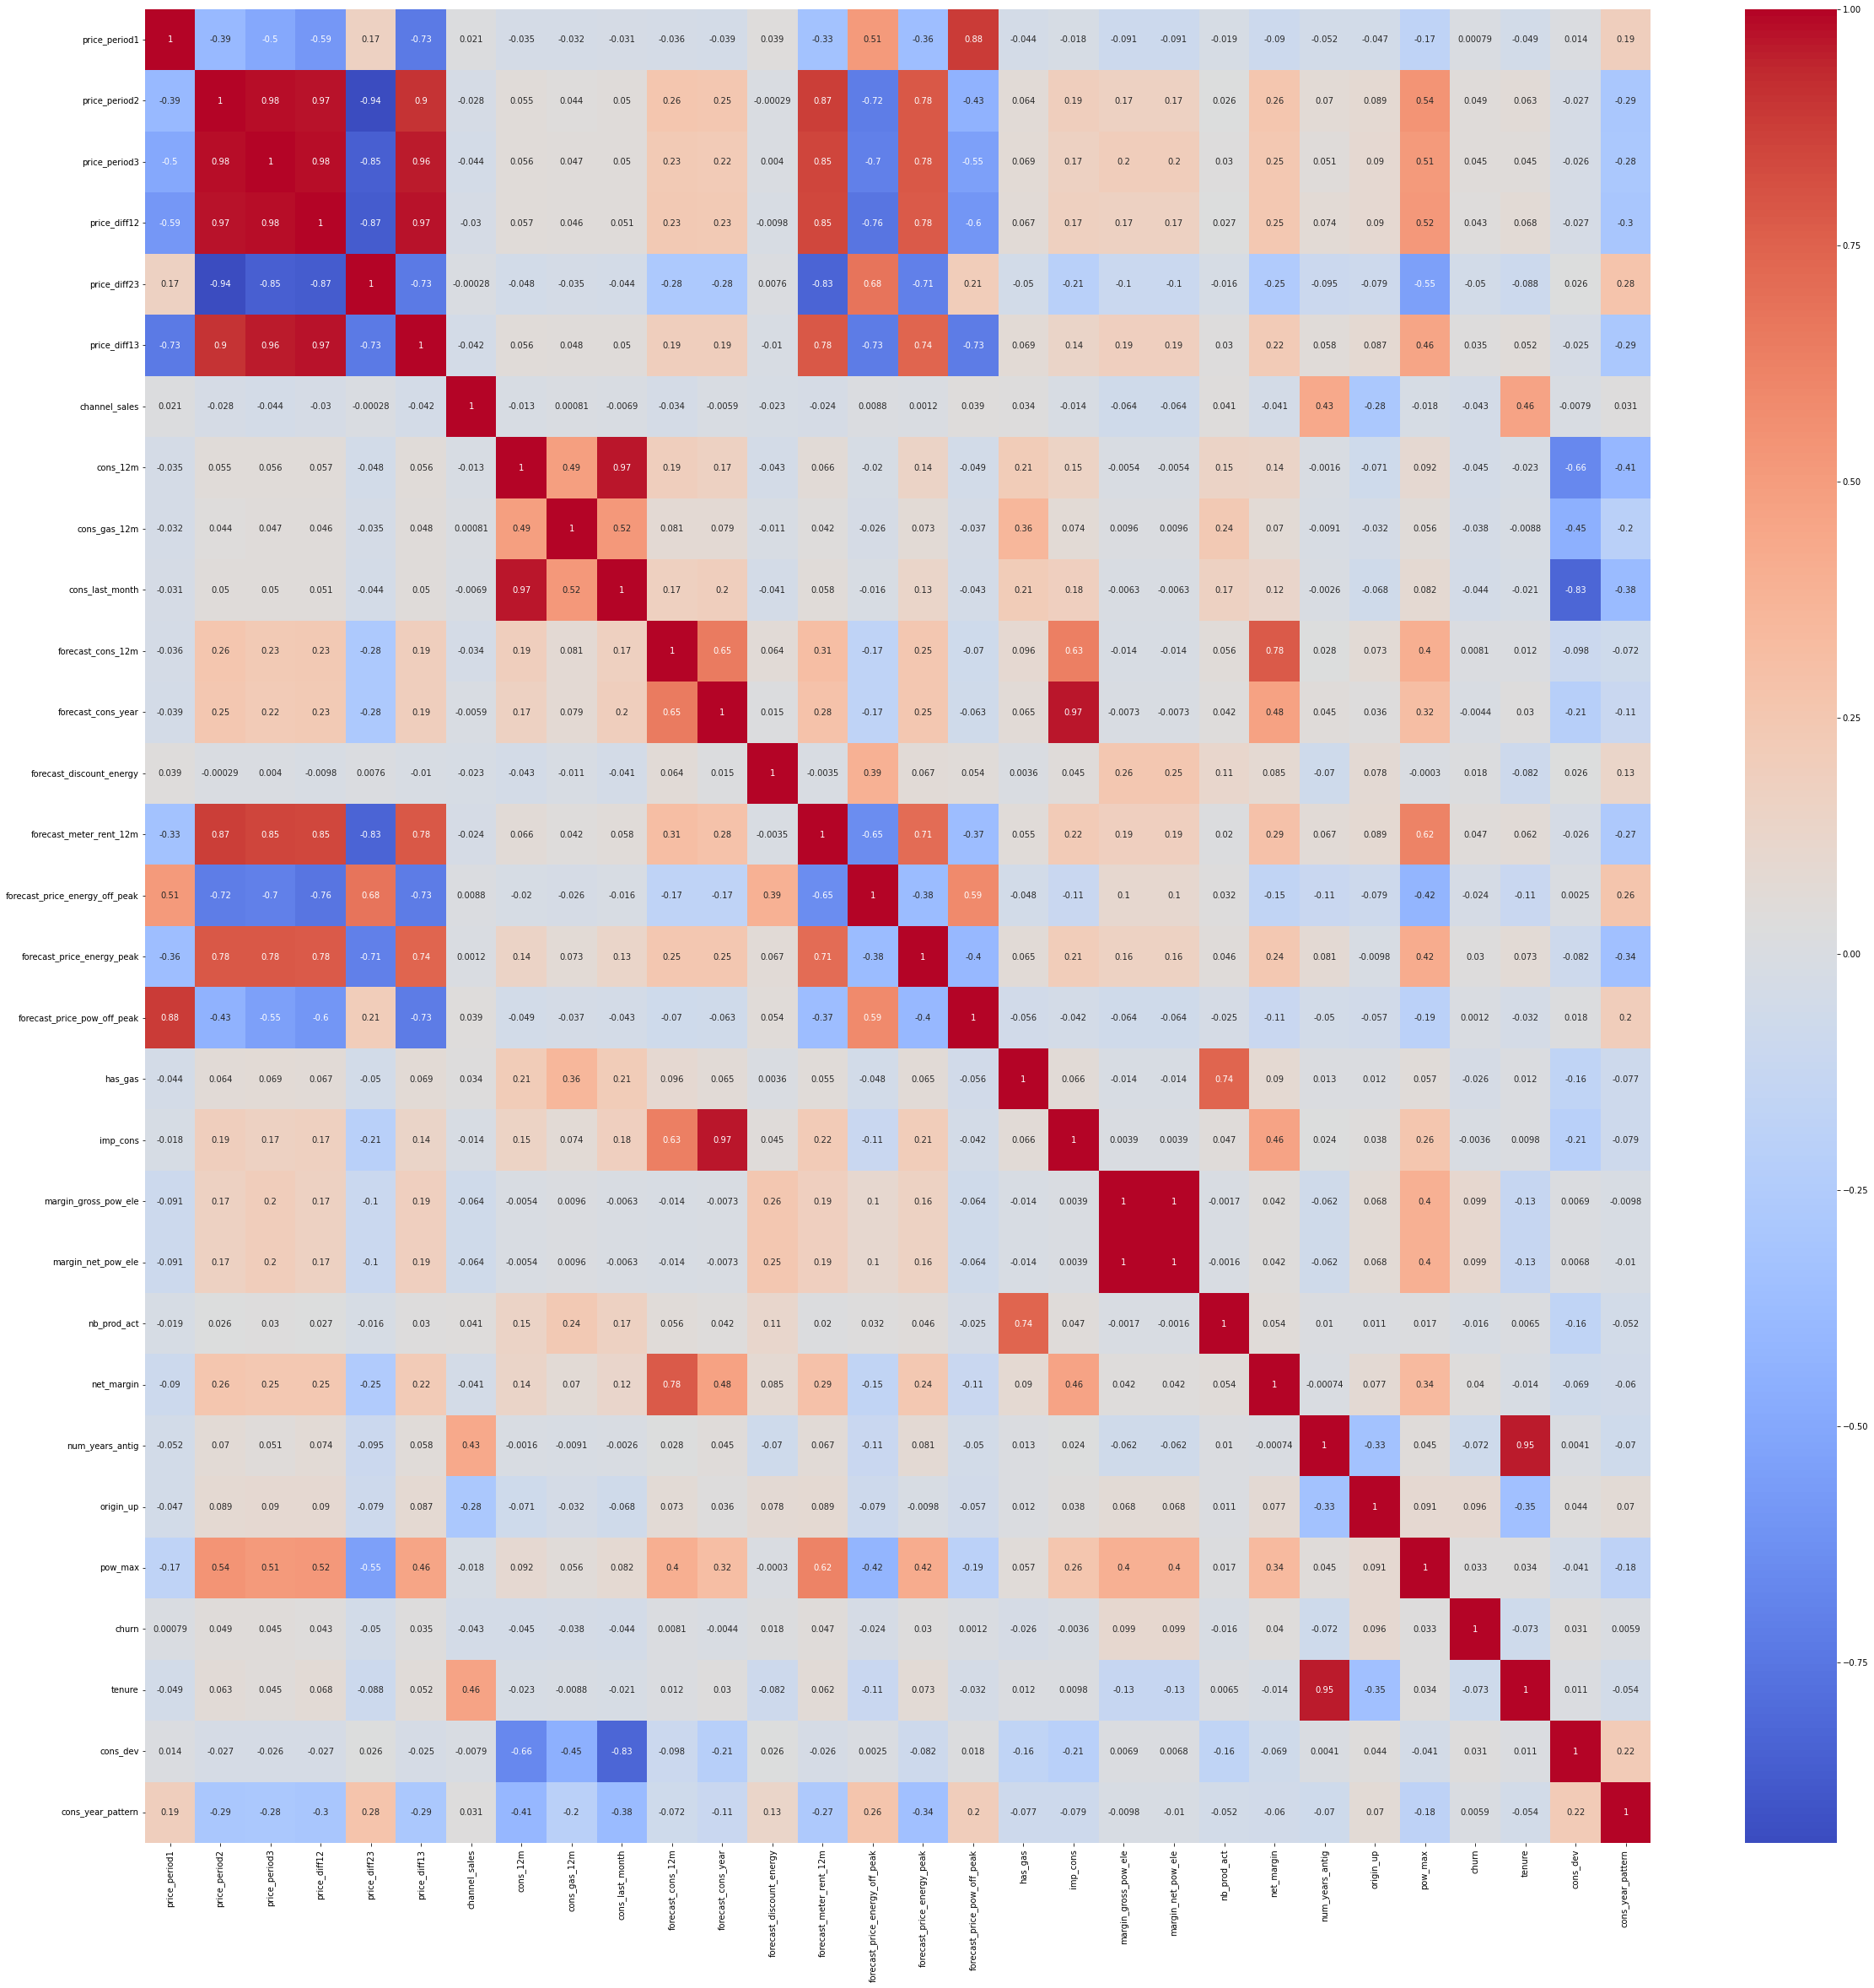

In [30]:
# correlation matrix
correlation = df.corr()
plt.figure(figsize=(40, 40))
sns.heatmap(correlation, annot=True, cmap='coolwarm')

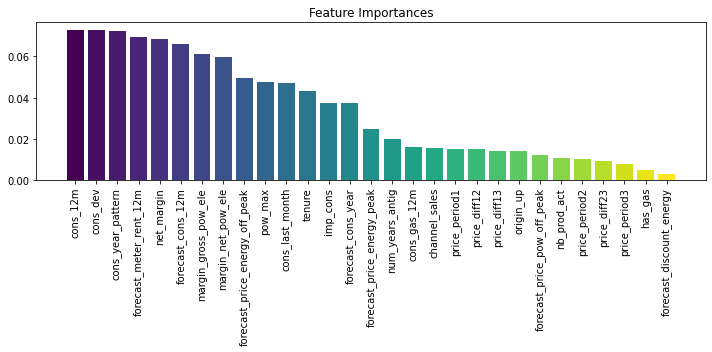

In [31]:
# Feature Importance
rf = RandomForestClassifier()
rf.fit(X, y)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 5))
plt.title('Feature Importances')
colors = plt.cm.viridis(np.linspace(0, 1, X.shape[1]))
plt.bar(range(X.shape[1]), importances[indices], align='center', color=colors)
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.tight_layout()
plt.show()

### Building Base Model 

In [32]:
# Defining models with unique keys
models = {
    'Random Forest (Default)': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=200, random_state=42),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
}

# Training and evaluating each model
for name, model in models.items():
    print(f"Training model: {name}")
    model.fit(X_train, y_train)
    
    # Predicting
    y_pred = model.predict(X_test)
    
    # Evaluating
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred))
    print('ROC and AUC score:',roc_auc_score(y_test, y_pred))
    print("-" * 50)


Training model: Random Forest (Default)
Classification Report for Random Forest (Default):
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     10168
           1       1.00      0.93      0.96      1106

    accuracy                           0.99     11274
   macro avg       1.00      0.97      0.98     11274
weighted avg       0.99      0.99      0.99     11274

ROC and AUC score: 0.9655927791048895
--------------------------------------------------
Training model: Logistic Regression


c:\Users\adnan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     10168
           1       0.09      0.00      0.00      1106

    accuracy                           0.90     11274
   macro avg       0.50      0.50      0.47     11274
weighted avg       0.82      0.90      0.86     11274

ROC and AUC score: 0.49996034077764795
--------------------------------------------------
Training model: XGBoost
Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     10168
           1       0.99      0.09      0.16      1106

    accuracy                           0.91     11274
   macro avg       0.95      0.54      0.56     11274
weighted avg       0.92      0.91      0.87     11274

ROC and AUC score: 0.5428983848915081
--------------------------------------------------


- **Random Forest**
    - **High Performance**: Excellent precision, recall, and F1-score for both classes.
    
    - **Class Imbalance Handled Well**: Model accurately predicts the minority class (1) with high F1-score (0.97).
    - **Accuracy**: Almost perfect (99%).
- **Logistic Regression**
    - **Good for Majority Class**: Performs well on class 0 with high precision (0.90) and recall (1.00).

    - **Poor for Minority Class**: Extremely low precision (0.25), recall (0.01), and F1-score (0.01) for class 1.
    - **Imbalance Issue**: Model struggles to identify minority class due to imbalanced dataset.
- **XGBoost** 
    - **Good Majority Class Prediction**: High precision (0.91) and recall (1.00) for class 0.

    - **Struggles with Minority Class**: While precision is high (0.99), recall is very low (0.09), indicating poor coverage of class 1.
    - **Accuracy**: Overall accuracy is high (91%), but this is mainly due to the correct prediction of the majority class.
- **Insights**

    - **Retention (Class 0)**: All models perform well in identifying retained customers.

    - **Churn (Class 1)**: Random Forest effectively balances precision and recall, making it the best model for churn prediction.
    - **Failure**: Logistic Regression and XGBoost fail to detect churn cases, likely due to the class imbalance.
    - **Need for Balancing Techniques**: SMOTE or class weighting could improve Logistic Regression and XGBoost performance on the minority class.

### Hyperparameter Tuning Random Forest

In [33]:
# Hyperparameter tuning for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3)
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")
print(f"Best estimator: {grid_search.best_estimator_}")
print("-" * 50)


Best parameters: {'max_depth': 15, 'n_estimators': 100}
Best score: 0.9281295328310138
Best estimator: RandomForestClassifier(max_depth=15, random_state=42)
--------------------------------------------------


In [34]:
y_pred = grid_search.predict(X_test)
print("Classification Report for Random Forest (Tuned):")
print(classification_report(y_test, y_pred))
print('ROC and AUC score:',roc_auc_score(y_test, y_pred))

Classification Report for Random Forest (Tuned):
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     10168
           1       1.00      0.32      0.48      1106

    accuracy                           0.93     11274
   macro avg       0.97      0.66      0.72     11274
weighted avg       0.94      0.93      0.92     11274

ROC and AUC score: 0.6577757685352622


- The hyperparameters might be too restrictive, causing the tuned model to underfit the data. For example, limiting tree depth or the number of splits excessively can reduce the model's ability to capture relationships.
- Therefore, not required and we go for the Default Random Search Model
